# Solar energy - Installations Efficiency Predictions
We'll only keep one station, and try to make predictions 
- for one MONTH with basic ML models using scikit learn
- for one or two days using a deep learning and tensor flow

import de toutes les librairies nécessaires

In [1]:
# pour la manipulation de données
import numpy as np
import pandas as pd

# pour tracer les graphes
import seaborn as sns
import matplotlib.pyplot as plt

# options d'affichage
pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings("ignore")

## Data preparation

chargement du fichier csv dans un dataframe

In [2]:
df = pd.read_csv("solar_generation_by_station.csv")

fonction qui ajoute les dates avec l'année, le mois, le numéro de la semaine et du jour dans l'année, l'heure de la journée

In [3]:
def add_date_time(_df):
    "Returns a DF with two new cols : the time and hour of the day"
    t = pd.date_range(start='1/1/1986', periods=_df.shape[0], freq = 'H')
    t = pd.DataFrame(t)
    _df = pd.concat([_df, t], axis=1)
    _df.rename(columns={ _df.columns[-1]: "time" }, inplace = True)
    _df['year'] = _df['time'].dt.year
    _df['month'] = _df['time'].dt.month
    _df['week'] = _df['time'].dt.weekofyear
    _df['day'] = _df['time'].dt.dayofyear    
    _df['hour'] = _df['time'].dt.hour
    return _df

on ne conserve que quelques années et les colonnes qui nous interesse.

In [4]:
df = add_date_time(df)
df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]

# keeping only values for one country for the predictions
df = df[['FR10', 'year', 'month', 'week', 'day', 'hour', 'time']]
df.head(2)

,FR10,year,month,week,day,hour,time
0,0.0,1986,1,1,1,0,1986-01-01 00:00:00
1,0.0,1986,1,1,1,1,1986-01-01 01:00:00


nombre de ligne du dataframe et de colonnes

In [5]:
df.shape

(201480, 7)

séparation du jeux données en 
- une partie pour le train : sert à l'entrainement du modèle, le modèle connait les valeurs de rendement sur ce jeu de donnée
- une partie pour le test : le modèle n'a jamais vu ce jeu de données et ne connait pas les valeurs de rendements.

In [6]:
# train data for 10 years
train_data = df[-24*365*10:-24*31]

# test data = last month of records / 2015
test_data = df[-24*31:]

# Model Training

## metrique

Comme vu précédmeent dans l'analyse exploratoire, le jeux de données est propre : il n'y a pas de valeur abérrante, pas de ligne dupliquée, par de valeurs manquantes. Nous allons utiliser la root mean square error comme métrique pour évaluer la performance des modèles.

Nous allons tester plusieurs type de regression pour faire des prédictions de rendement de l'installation photovoltaique. Pour trouver quel est le modèle le plus performant nous allons comparer les erreurs sur la partie test du jeux de donnée

In [7]:
from sklearn.metrics import mean_squared_error
model_instances, model_names, rmse_train, rmse_test = [], [], [], []

# cette fonction ne sert qu'a afficher les diagrammes à barre des erreurs des différents modèles

def plot_scores():
    df_score = pd.DataFrame({'model_names' : model_names,
                             'rmse_train' : rmse_train,
                             'rmse_test' : rmse_test})
    df_score = pd.melt(df_score, id_vars=['model_names'], value_vars=['rmse_train', 'rmse_test'])

    plt.figure(figsize=(12, 10))
    sns.barplot(y="model_names", x="value", hue="variable", data=df_score)
    plt.show()

## baseline

modèle de base pour le comparer aux autres, il s'agit d'un prédicateur relativement simple qui prend la moyenne des années passées : par exemple pour le jour 358 de l'année à l'heure entre 12 et 13h, ce modèle retourne la valeur moyenne des 10 années passées...

In [8]:
x_train, y_train = train_data.drop(columns=['time']), train_data['FR10']
x_test, y_test = test_data.drop(columns=['time']), test_data['FR10']

In [9]:
def mean_df(d, h):
    "return the hourly mean of a specific day of the year"
    res = x_train[(x_train['day'] == d) & (x_train['hour'] == h)]['FR10'].mean()
    return res

    # examples 
    #df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
    # x_train[(x_train['day'] == x['day']) & (x_train['hour'] == x['hour'])]['FR10'].mean()

In [10]:
#x_train['pred'] = x_train.apply(lambda x: mean_df(x.day, x.hour), axis=1)
x_test['pred'] = x_test.apply(lambda x: mean_df(x.day, x.hour), axis=1)

affichage du jeux de donnée de test avec la prediction : colonne "pred"

In [11]:
x_test.head()

,FR10,year,month,week,day,hour,pred
262224,0.0,2015,12,49,335,0,0.0
262225,0.0,2015,12,49,335,1,0.0
262226,0.0,2015,12,49,335,2,0.0
262227,0.0,2015,12,49,335,3,0.0
262228,0.0,2015,12,49,335,4,0.0


ajout des erreurs dans des listes qui serviront pour l'affichage du diagramme à barre

In [12]:
model_names.append("base_line")
rmse_train.append(np.sqrt(mean_squared_error(x_train['FR10'], x_train['FR10']))) # a modifier en pred
rmse_test.append(np.sqrt(mean_squared_error(x_test['FR10'], x_test['pred'])))

affichage des prédictions pour le dernier mois (en orange) et des valeurs réelles (en bleu)

In [13]:
def plot_predictions(data):
    plt.figure(figsize=(18, 8))
    sns.lineplot(data=data)
    plt.title("Base line predictions (orange) vs real values (blue) for the last month")
    plt.xlabel("hours of the last month (12-2015)")
    plt.ylabel("solar installation efficiency")
    plt.show()

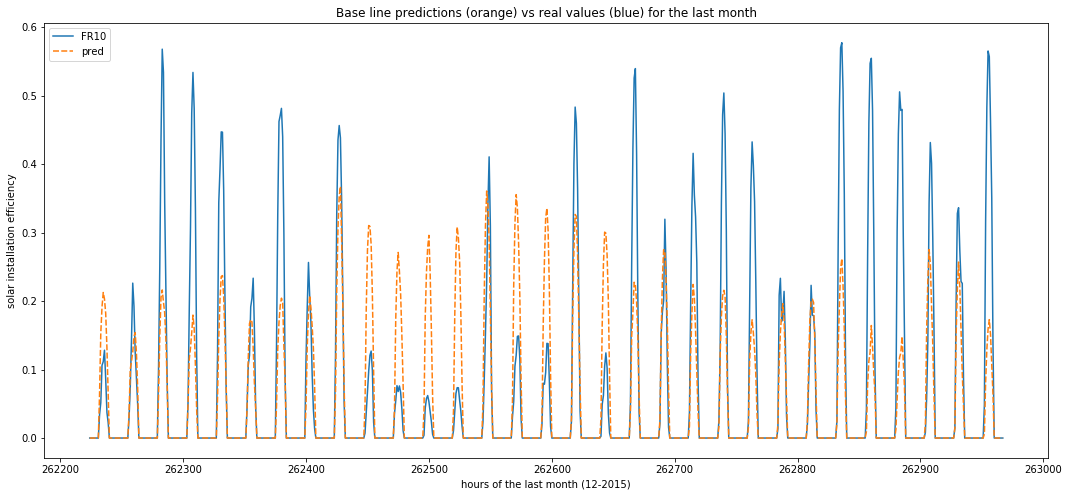

In [14]:
plot_predictions(data=x_test[['FR10', 'pred']])

## basic regression models

ici nous allons utiliser plusieurs modèles de régresssion linéaires

In [15]:
X_train, y_train = train_data[['month', 'week', 'day', 'hour']], train_data['FR10']
X_test, y_test = test_data[['month', 'week', 'day', 'hour']], test_data['FR10']
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((86856, 4), (86856,), (744, 4), (744,))

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgbm

In [17]:
def get_rmse(reg, model_name):
    """Print the score for the model passed in argument and retrun scores for the train/test sets"""
    
    y_train_pred, y_pred = reg.predict(X_train), reg.predict(X_test)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name, f'\t - RMSE on Training  = {rmse_train:.2f} / RMSE on Test = {rmse_test:.2f}')
    
    return rmse_train, rmse_test

In [18]:
# list of all the basic models used at first
model_list = [
    LinearRegression(), Lasso(), Ridge(), ElasticNet(),
    RandomForestRegressor(), GradientBoostingRegressor(), ExtraTreesRegressor(),
    xgb.XGBRegressor(), lgbm.LGBMRegressor(), KNeighborsRegressor()
             ]

# creation of list of names and scores for the train / test
model_names.extend([str(m)[:str(m).index('(')] for m in model_list])


# fit and predict all models
for model, name in zip(model_list, model_names):
    model.fit(X_train, y_train)
    sc_train, sc_test = get_rmse(model, name)
    rmse_train.append(sc_train)
    rmse_test.append(sc_test)

base_line 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
LinearRegression 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Lasso 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Ridge 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
ElasticNet 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
RandomForestRegressor 	 - RMSE on Training  = 0.11 / RMSE on Test = 0.09
GradientBoostingRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
ExtraTreesRegressor 	 - RMSE on Training  = 0.11 / RMSE on Test = 0.09
XGBRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10
LGBMRegressor 	 - RMSE on Training  = 0.10 / RMSE on Test = 0.10


the Support Vector Machine (both linear and poly kernels) aren't efficient enough :

In [19]:
print("""
svm_lin = LinearSVR()
svm_lin.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_lin, "SVM lin.")
model_names.append("SVM lin.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM lin. 	 - RMSE on Training  = 0.31 / RMSE on Test = 0.30
""")


svm_lin = LinearSVR()
svm_lin.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_lin, "SVM lin.")
model_names.append("SVM lin.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM lin. 	 - RMSE on Training  = 0.31 / RMSE on Test = 0.30



In [20]:
print("""
svm_poly = SVR(kernel='poly', degree=4, max_iter=100)
svm_poly.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_poly, "SVM poly.")
model_names.append("SVM poly.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM poly. 	 - RMSE on Training  = 0.52 / RMSE on Test = 0.56
""")


svm_poly = SVR(kernel='poly', degree=4, max_iter=100)
svm_poly.fit(X_train, y_train)
sc_train, sc_test = get_rmse(svm_poly, "SVM poly.")
model_names.append("SVM poly.")
rmse_train.append(sc_train)
rmse_test.append(sc_test)

SVM poly. 	 - RMSE on Training  = 0.52 / RMSE on Test = 0.56



if we use polynomial features to elevate date time infos to different powers

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


poly_lin_reg = Pipeline([
    ("poly_feat", PolynomialFeatures(degree=4)),
    ("linear_reg", LinearRegression())
])

poly_lin_reg.fit(X_train, y_train)

sc_train, sc_test = get_rmse(poly_lin_reg, "Poly Linear Reg")

model_names.append('Poly Linear Reg')
rmse_train.append(sc_train)
rmse_test.append(sc_test)

Poly Linear Reg 	 - RMSE on Training  = 0.12 / RMSE on Test = 0.11


if we deal with date time infos as categorical featues, which is the right way to handle such data

In [22]:
# train data for 10 years
train_data_d = df[-24*365*10:][['FR10', 'month', 'week', 'day', 'hour']]

# one hot encoding for categorical feature
cat_feat = ['month', 'week', 'day', 'hour']
train_data_d = pd.get_dummies(data=train_data_d, columns=cat_feat, drop_first=True)
train_data_d.head()

# keep last month for the test data set
test_data_d, train_data_d = train_data_d[-24*31:], train_data_d[:-24*31]

# get_dummies or one hot encoding
X_train_d, y_train_d = train_data_d.drop(columns=['FR10']), train_data_d['FR10']
X_test_d, y_test_d = test_data_d.drop(columns=['FR10']), test_data_d['FR10']

# verify if different shapes match
X_train_d.shape, y_train_d.shape, X_test_d.shape, y_test_d.shape

((86856, 450), (86856,), (744, 450), (744,))

In [23]:
categorical_linreg = LinearRegression()
categorical_linreg.fit(X_train, y_train)
sc_train, sc_test = get_rmse(categorical_linreg, "Categorical lin. reg.")
print("Not more efficient than linear regression without get dummies")

Categorical lin. reg. 	 - RMSE on Training  = 0.21 / RMSE on Test = 0.15
Not more efficient than linear regression without get dummies


Let's see predictions from the GradientBoostingRegressor Model versus the ground truth

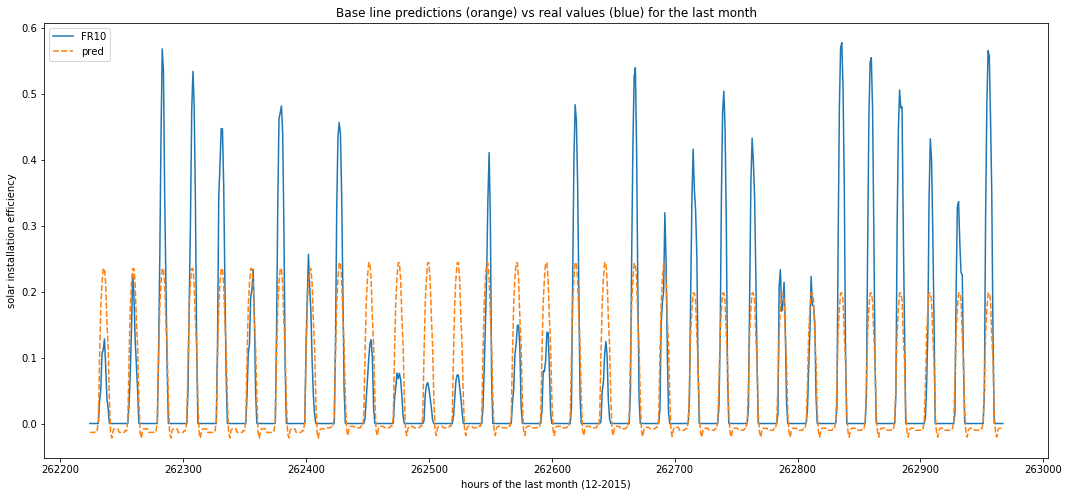

In [24]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred = pd.DataFrame(gbr.predict(X_test))

y_test = pd.DataFrame(y_test)
y_test['pred'] = y_pred.values

plot_predictions(data=y_test)

## With prophet a facebook lib for time series

Prophet est une librairie python de machine learning crée récemment par facebook.

Prophet suit le modèle d'API de scikit learn. nous créons une instance de classe Prophet et nous appelons ses méthodes "fit" et "predict".

L'entrée pour Prophet est toujours un dataframe avec 2 colonnes: ds et y. la colonne ds (datestamp) doit être de la forme  YYYY-MM-DD HH:MM:SS. la colonne y doit être numérique, et représente la mesure à prédire.

In [25]:
# on recharge les données comme avant
df = pd.read_csv("solar_generation_by_station.csv")
df = add_date_time(df)
#df = df[~df.year.isin([1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016])]

In [26]:
# on ne conserve que ce qui nous interesse
data = df[['time', 'FR10']]
data = data.rename(columns={"time": "ds", "FR10": "y"})

# pour la partie train on prend les 10 dernières années
train_data = data[-24*365*10:-24*31]

# pour la partie test que le dernier mois de 2015
test_data = data[-24*31:]

utilisons prophet sur les dernières données préparées

In [27]:
from fbprophet import Prophet

prophet_model = Prophet()
prophet_model.fit(train_data)
test_data.tail()
#y_train_pred = prophet_model.predict(train_data)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


,ds,y
262963,2015-12-31 19:00:00,0.0
262964,2015-12-31 20:00:00,0.0
262965,2015-12-31 21:00:00,0.0
262966,2015-12-31 22:00:00,0.0
262967,2015-12-31 23:00:00,0.0


In [28]:
forecast = prophet_model.predict(test_data)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast['FR10'] = test_data['y'].values
forecast.tail()

,ds,yhat,yhat_lower,yhat_upper,FR10
739,2015-12-31 19:00:00,-0.082307,-0.231659,0.062977,0.0
740,2015-12-31 20:00:00,-0.077637,-0.227244,0.074729,0.0
741,2015-12-31 21:00:00,-0.071139,-0.227988,0.088416,0.0
742,2015-12-31 22:00:00,-0.073426,-0.231074,0.086041,0.0
743,2015-12-31 23:00:00,-0.080386,-0.225916,0.074870,0.0


- "prophet" : correspond à la prédiction
- "prophet_lower" : correspond à une prédiction de la borne inférieure
- "prophet_upper" : même chose mais pour la borne supérieure

In [29]:
model_names.append("prophet") #.extend(["prophet", "prophet_lower", "prophet_upper"])

rmse_train.append(0)
#rmse_train.extend([0, 0, 0])
rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat'])))
#rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_lower'])))
#rmse_test.append(np.sqrt(mean_squared_error(test_data['y'], forecast['yhat_upper'])))

affichage de la prédiction et des valeurs réelles de rendement de l'installation photovoltaique

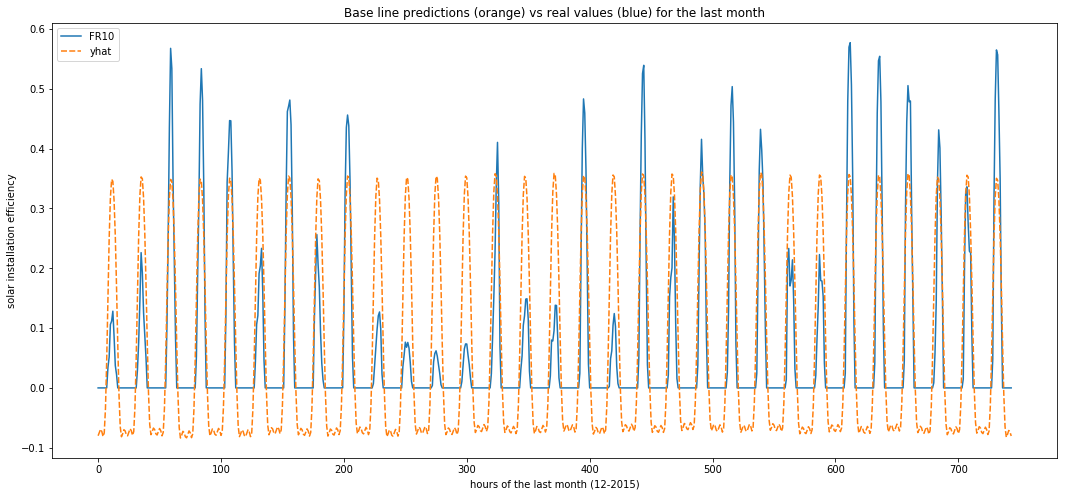

In [30]:
plot_predictions(data=forecast[['FR10', 'yhat']])

# if we wanted to plot aslo inf / sup
# plt.figure(figsize=(18, 8))
# sns.lineplot(data=forecast[['FR10', 'yhat_lower', 'yhat_upper']])

# Using deep learning models

In [31]:
df = pd.read_csv("solar_generation_by_station.csv")
df = df[sorted([c for c in df.columns if 'FR' in c])]

# keep only 4 years
df = df[-24*365*4:]

# nb lines / cols
df.shape

(35040, 22)

We will now try to make a prediction of the FR10 value of an hour, based on all the features (all other station efficiencies) of the past 2 days (48 hrs).

Before doing so, we need to create the (X, y) dataset.

Let's consider your action Name has 100 lines.
The X values should contain, in each line, a table of 48 hrs and 22 features. So that the final X array will have the shape ((100-48+1), 48, 22).

The corresponding y values should be the station efficiency of the hours 49 (indeed, y can not contain the 48 first hours, since we need 2 days of X to predict before). So the final y array will have the shape ((100-48+1), 1) (or equivalently (53,)).

In [32]:
def process_data(data, past):
    X = []
    for i in range(len(data)-past-1):
        X.append(data.iloc[i:i+past].values)
    return np.array(X)


lookback = 48

y = df['FR10'][lookback+1:] 
X = process_data(df, lookback)
X.shape, y.shape

((34991, 48, 22), (34991,))

We don't need to scale the values since they are already between 0 and 1. So let's start by building a simple RNN model. Before we need to split the data set in two parts for training and test purposes. We can use the parameter shuffle=False in the scikit learn train_test_split method so that the last 20% will correspond to the end of our hourly records and not randomly choosen lines of the dataframe.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27992, 48, 22), (6999, 48, 22), (27992,), (6999,))

## RNN

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout


def my_RNN():
    my_rnn = Sequential()
    my_rnn.add(SimpleRNN(units=32, return_sequences=True, input_shape=(lookback,22)))
    my_rnn.add(SimpleRNN(units=32, return_sequences=True))
    my_rnn.add(SimpleRNN(units=32, return_sequences=False))
    my_rnn.add(Dense(units=1, activation='linear'))
    return my_rnn


rnn_model = my_RNN()
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Train on 27992 samples, validate on 6999 samples
Epoch 1/50
27992/27992 [==============================] - 8s 275us/sample - loss: 0.0134 - val_loss: 0.0064
Epoch 2/50
27992/27992 [==============================] - 6s 220us/sample - loss: 0.0058 - val_loss: 0.0056
Epoch 3/50
27992/27992 [==============================] - 6s 219us/sample - loss: 0.0053 - val_loss: 0.0051
Epoch 4/50
27992/27992 [==============================] - 6s 222us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 5/50
27992/27992 [==============================] - 6s 219us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 6/50
27992/27992 [==============================] - 7s 248us/sample - loss: 0.0043 - val_loss: 0.0049
Epoch 7/50
27992/27992 [==============================] - 7s 235us/sample - loss: 0.0042 - val_loss: 0.0058
Epoch 8/50
27992/27992 [==============================] - 7s 235us/sample - loss: 0.0041 - val_loss: 0.0045
Epoch 9/50
27992/27992 [==============================] - 7s 234us/sample - loss: 0.003

In [36]:
y_pred_train, y_pred_test = rnn_model.predict(X_train), rnn_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.049438566199644735, 0.053245751630238404)

In [37]:
def append_results(model_name):
    model_names.append(model_name)
    rmse_train.append(err_train)
    rmse_test.append(err_test)

append_results("RNN")

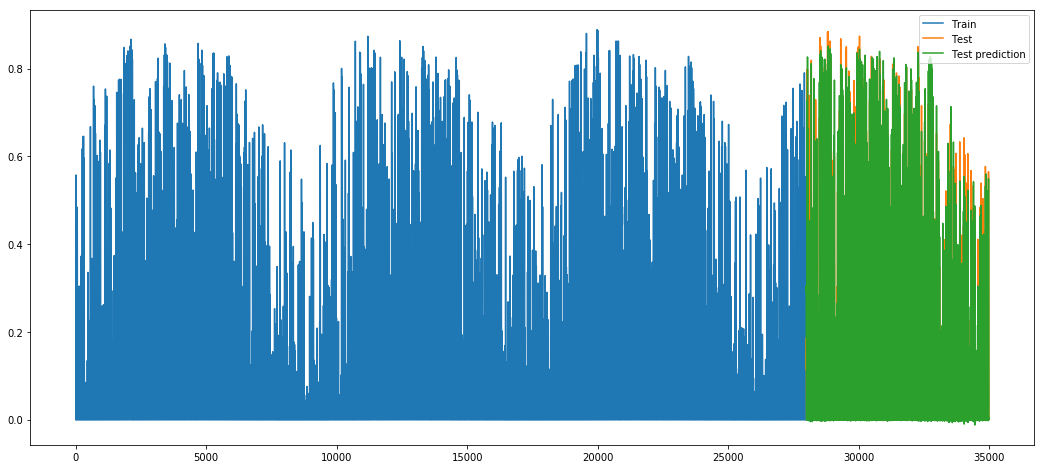

In [38]:
def plot_evolution():
    plt.figure(figsize=(18, 8))
    plt.plot(np.arange(len(X_train)), y_train, label='Train')
    plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_test, label='Test')
    plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_pred_test, label='Test prediction')
    plt.legend()
    plt.show()

plot_evolution()

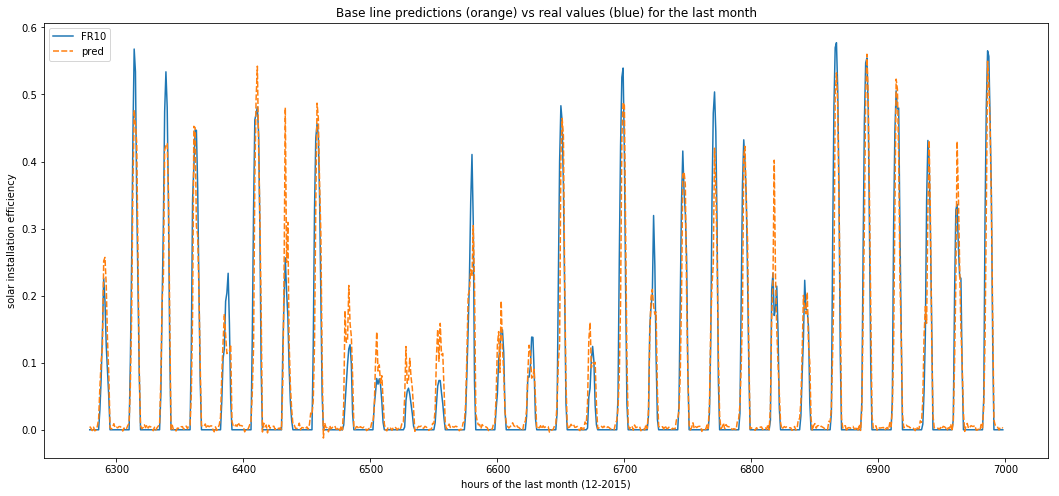

In [41]:
rnn_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['FR10', 'pred'])
plot_predictions(data=rnn_res[-30*24:])

## GRU

In [42]:
from tensorflow.keras.layers import GRU

def my_GRU(input_shape):
    my_GRU = Sequential()
    my_GRU.add(GRU(units=32, return_sequences=True, activation='relu', input_shape=input_shape))
    my_GRU.add(GRU(units=32, activation='relu', return_sequences=False))
    my_GRU.add(Dense(units=1, activation='linear'))
    return my_GRU

gru_model = my_GRU(X.shape[1:])
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Train on 27992 samples, validate on 6999 samples
Epoch 1/50
27992/27992 [==============================] - 26s 925us/sample - loss: 0.0079 - val_loss: 0.0045
Epoch 2/50
27992/27992 [==============================] - 25s 886us/sample - loss: 0.0041 - val_loss: 0.0044
Epoch 3/50
27992/27992 [==============================] - 25s 882us/sample - loss: 0.0037 - val_loss: 0.0037
Epoch 4/50
27992/27992 [==============================] - 25s 881us/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 5/50
27992/27992 [==============================] - 25s 883us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 6/50
27992/27992 [==============================] - 25s 895us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 7/50
27992/27992 [==============================] - 27s 962us/sample - loss: 0.0032 - val_loss: 0.0035
Epoch 8/50
27992/27992 [==============================] - 26s 924us/sample - loss: 0.0032 - val_loss: 0.0039
Epoch 9/50
27992/27992 [==============================] - 26s 921us/sample - lo

In [43]:
y_pred_train, y_pred_test = gru_model.predict(X_train), gru_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.043378528763354136, 0.05491103360728014)

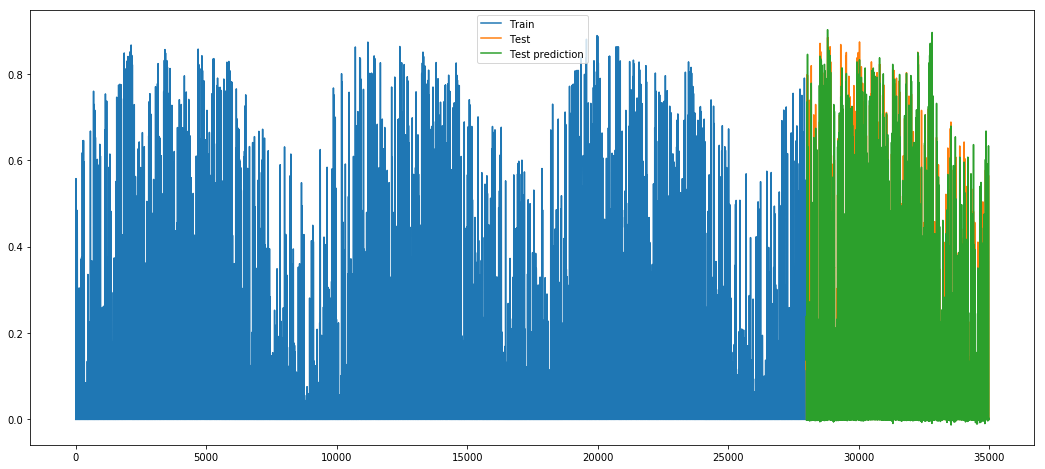

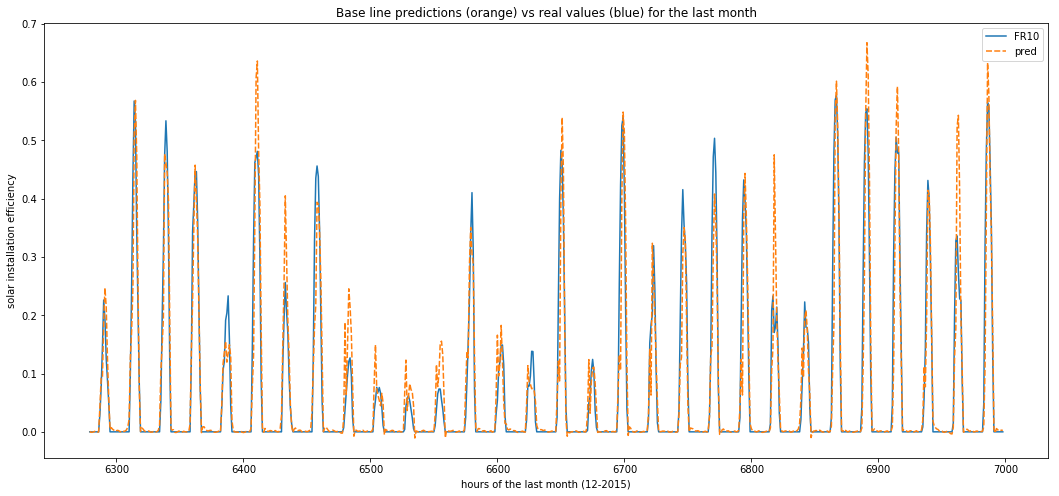

In [45]:
append_results("GRU")
plot_evolution()

gru_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['FR10', 'pred'])
plot_predictions(data=gru_res[-30*24:])

## LSTM

In [46]:
from tensorflow.keras.layers import LSTM

def my_LSTM(input_shape):
    my_LSTM = Sequential()
    my_LSTM.add(LSTM(units=32, return_sequences=True, activation='relu', input_shape=input_shape))
    my_LSTM.add(LSTM(units=32, activation='relu', return_sequences=False))
    my_LSTM.add(Dense(units=1, activation='linear'))
    return my_LSTM

lstm_model = my_LSTM(X.shape[1:])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Train on 27992 samples, validate on 6999 samples
Epoch 1/50
27992/27992 [==============================] - 33s 1ms/sample - loss: 0.0095 - val_loss: 0.0055
Epoch 2/50
27992/27992 [==============================] - 29s 1ms/sample - loss: 0.0043 - val_loss: 0.0051
Epoch 3/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0038 - val_loss: 0.0040
Epoch 4/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0036 - val_loss: 0.0034
Epoch 5/50
27992/27992 [==============================] - 31s 1ms/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 6/50
27992/27992 [==============================] - 32s 1ms/sample - loss: 0.0032 - val_loss: 0.0036
Epoch 7/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0032 - val_loss: 0.0034
Epoch 8/50
27992/27992 [==============================] - 30s 1ms/sample - loss: 0.0031 - val_loss: 0.0033
Epoch 9/50
27992/27992 [==============================] - 29s 1ms/sample - loss: 0.0031 - val_l

In [47]:
y_pred_train, y_pred_test = lstm_model.predict(X_train), lstm_model.predict(X_test)
err_train, err_test = np.sqrt(mean_squared_error(y_train, y_pred_train)), np.sqrt(mean_squared_error(y_test, y_pred_test))
err_train, err_test

(0.045058438093560825, 0.05383881283306442)

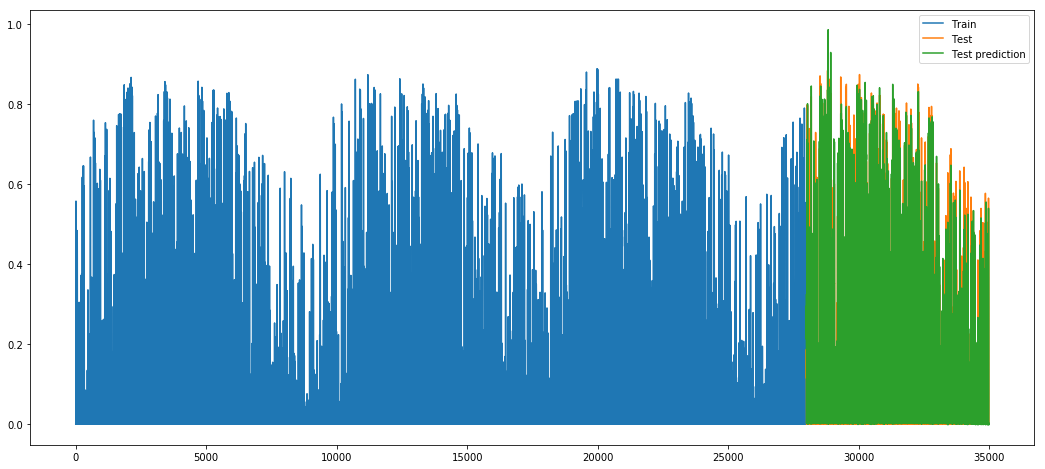

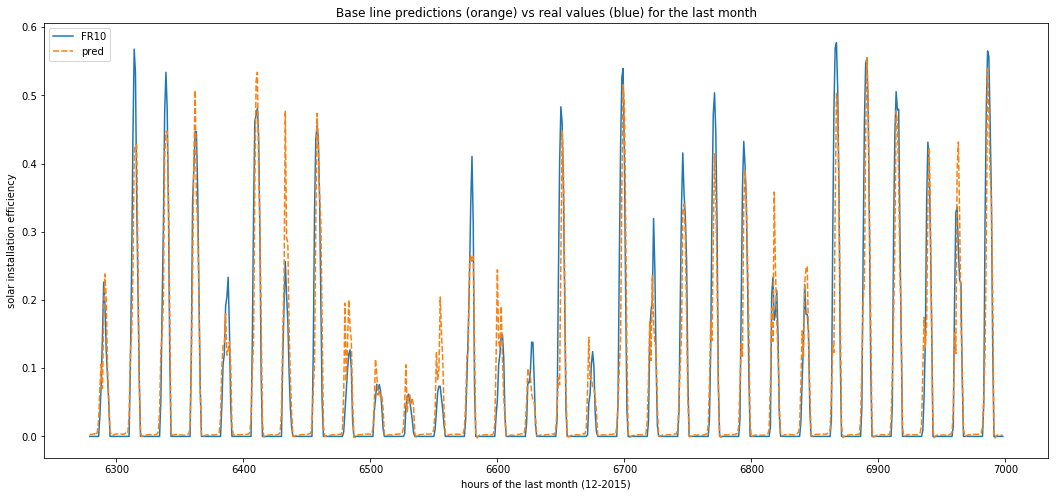

In [49]:
append_results("LSTM")
plot_evolution()

lstm_res = pd.DataFrame(zip(list(y_test), list(np.squeeze(y_pred_test))), columns =['FR10', 'pred'])
plot_predictions(data=lstm_res[-30*24:])

---

# Conclusions

In [55]:
len(model_names), len(rmse_train), len(rmse_test)

(17, 17, 17)

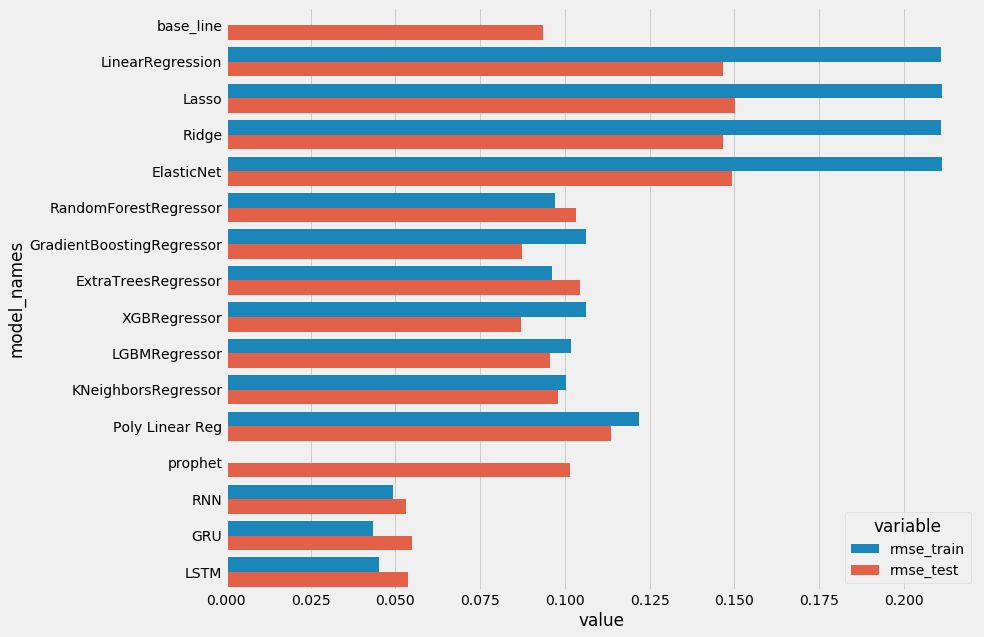

In [56]:
plt.style.use('fivethirtyeight')
plot_scores()

- LGBM regressor par exemple présente une erreur de 0.1 environ sur la partie test. cette erreur est à relativiser par rapport aux valeurs de rendements qui vont de 0 à 1 en théorie (dans la pratique elle dépasse rarement 0.7)

- Finalememnt peu de modèles sont meilleurs que la baseline, mais sans différence vraiment notoire.
- la bibliothèque de Facebook n'est pas si performante pour ce genre de prédiction.

## Simplified conclusion

on enlève les deux dernières valeurs qui correspondent aux bornes inf et sup de prophet qui n'apportent rien de plus.

pour simplifier on ne considère pas la partie train, on ne regarde que l'erreur sur le test. Car le jeux de données test sert à évaluer le modèle sur des données qu'il ne connait pas

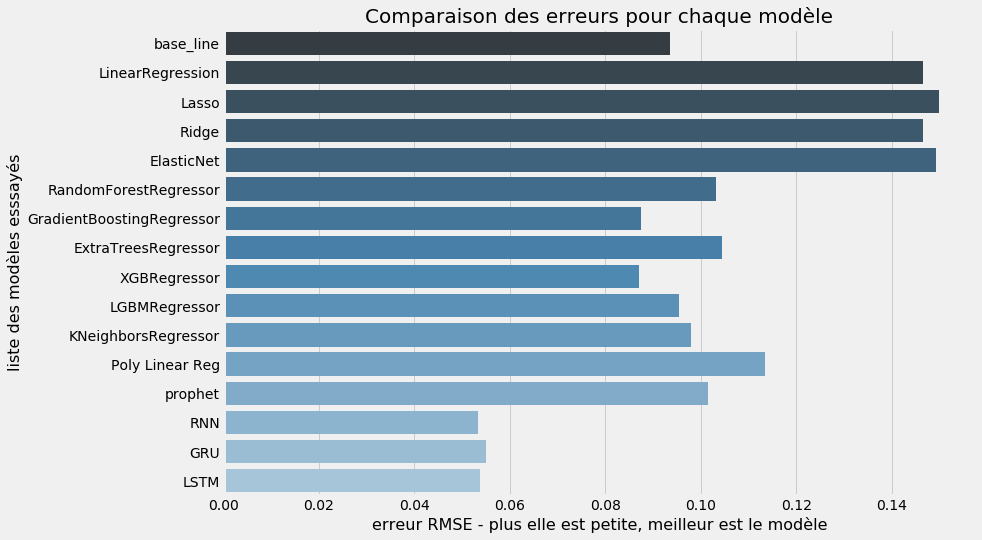

In [57]:
df_score = pd.DataFrame({'model_names' : model_names, 'rmse_test' : rmse_test})

plt.figure(figsize=(12, 8))
sns.barplot(y="model_names", x="rmse_test", data=df_score, palette="Blues_d")
plt.title("Comparaison des erreurs pour chaque modèle", fontsize=20)
plt.xlabel('erreur RMSE - plus elle est petite, meilleur est le modèle', fontsize=16)
plt.ylabel('liste des modèles esssayés', fontsize=16)
plt.show()